In [3]:
!pip install face_alignment


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [4]:
!pip install --upgrade pip

  Using cached pip-25.1.1-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-25.1.1-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 25.0.1
    Uninstalling pip-25.0.1:
      Successfully uninstalled pip-25.0.1


In [2]:
# %%
import face_alignment
from skimage import io
import numpy as np

In [ ]:

# Explicitly use CPU to avoid CUDA issues
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D, flip_input=False, device='cpu')

input = io.imread('/Users/ravee/Downloads/image.jpg')


In [24]:

# Convert RGBA to RGB if necessary (remove alpha channel)
print(f"Image shape: {input.shape}")
if input.shape[-1] == 4:
    input = input[:, :, :3]

print(f"Image shape: {input.shape}")
preds = fa.get_landmarks(input)

if preds is not None:
    print(f"Found {len(preds)} face(s)")
    for i, landmarks in enumerate(preds):
        print(f"Face {i+1}: {landmarks.shape[0]} landmarks detected")
else:
    print("No faces detected")



Image shape: (276, 242, 3)
Image shape: (276, 242, 3)
Found 1 face(s)
Face 1: 68 landmarks detected


In [27]:

# %%
import cv2
import matplotlib.pyplot as plt
from skimage.transform import SimilarityTransform
import numpy as np

def align_face(image, landmarks, output_size=(256, 256)):
    """
    Align face based on eye positions
    """
    # Get eye landmarks (assuming 68-point dlib landmarks)
    left_eye_center = landmarks[36:42].mean(axis=0)  # Left eye points
    right_eye_center = landmarks[42:48].mean(axis=0)  # Right eye points
    
    # Calculate the angle between eyes
    dx = right_eye_center[0] - left_eye_center[0]
    dy = right_eye_center[1] - left_eye_center[1]
    angle = np.arctan2(dy, dx) * 180 / np.pi
    
    # Calculate center between eyes
    eye_center = ((left_eye_center[0] + right_eye_center[0]) / 2,
                  (left_eye_center[1] + right_eye_center[1]) / 2)
    
    print(f"Aligning face with angle: {angle:.2f} degrees"
          f" at center: {eye_center}"
          f" with landmarks: {landmarks.shape[0]} points"
          f" and image shape: {image.shape}"
          )
    
    # Get rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(eye_center, angle, 1.0)

    print(f"Rotation matrix: {rotation_matrix}")
    
    # Rotate the image
    rotated = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))
    print(f"Rotated image shape: {rotated.shape}")
    
    # Calculate new landmark positions after rotation
    ones = np.ones(shape=(len(landmarks), 1))
    landmarks_ones = np.hstack([landmarks, ones])
    new_landmarks = rotation_matrix.dot(landmarks_ones.T).T
    
    # Calculate face bounding box from landmarks
    min_x, min_y = new_landmarks.min(axis=0)
    max_x, max_y = new_landmarks.max(axis=0)
    
    # Add some padding
    padding = 50
    min_x = max(0, int(min_x - padding))
    min_y = max(0, int(min_y - padding))
    max_x = min(rotated.shape[1], int(max_x + padding))
    max_y = min(rotated.shape[0], int(max_y + padding))
    
    # Crop the face region
    cropped = rotated[min_y:max_y, min_x:max_x]
    
    # Resize to output size
    aligned = cv2.resize(cropped, output_size)
    
    return aligned, rotated


Aligning face with angle: -168.50 degrees at center: (175.08334350585938, 329.25) with landmarks: 68 points and image shape: (546, 396, 3)
Rotation matrix: [[-9.79907928e-01 -1.99450374e-01  4.12317936e+02]
 [ 1.99450374e-01 -9.79907928e-01  6.16964247e+02]]
Rotated image shape: (546, 396, 3)


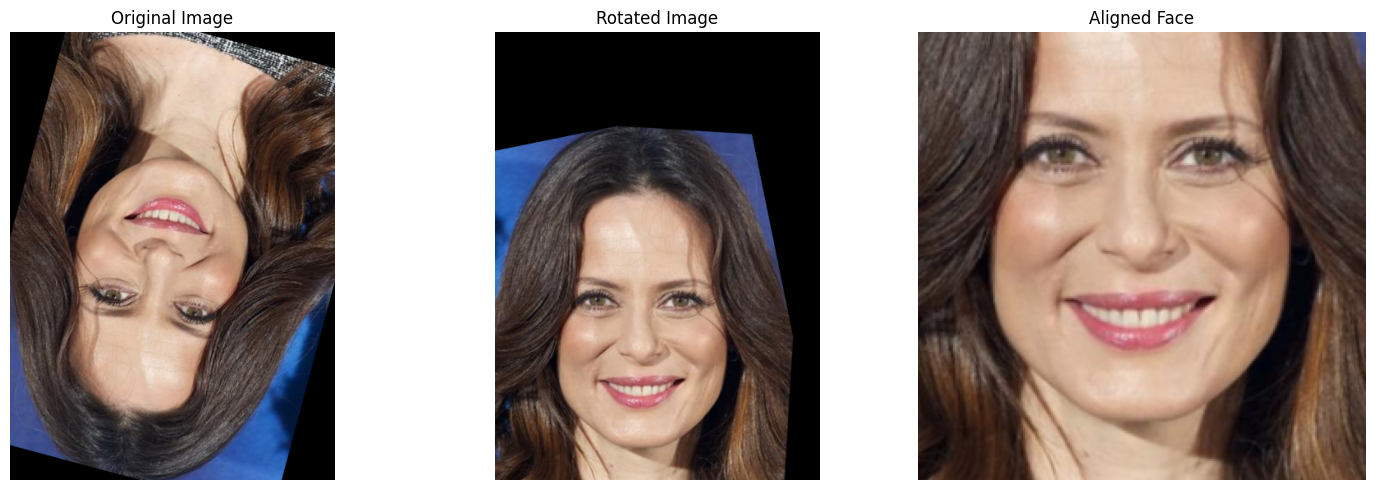

Original image shape: (546, 396, 3)
Aligned face shape: (256, 256, 3)


In [28]:

# Apply face alignment
if preds is not None and len(preds) > 0:
    aligned_face, rotated_image = align_face(input, preds[0])
    
    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(input)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Rotated image
    axes[1].imshow(rotated_image)
    axes[1].set_title('Rotated Image')
    axes[1].axis('off')
    
    # Aligned face
    axes[2].imshow(aligned_face)
    axes[2].set_title('Aligned Face')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Original image shape: {input.shape}")
    print(f"Aligned face shape: {aligned_face.shape}")
else:
    print("No faces detected for alignment")



In [35]:

# %%
from skimage.transform import SimilarityTransform, warp

def align_face_5points(image, landmarks, output_size=(256, 256)):
    """
    Align face using 5-point alignment (more standard for face recognition)
    Uses eye centers and nose tip
    """
    # Extract key points from 68-landmark format
    left_eye = landmarks[36:42].mean(axis=0)   # Left eye center
    right_eye = landmarks[42:48].mean(axis=0)  # Right eye center
    nose_tip = landmarks[30]                   # Nose tip
    mouth_left = landmarks[48]                 # Left mouth corner
    mouth_right = landmarks[54]                # Right mouth corner
    
    # Standard template for aligned face (these are the target positions)
    template = np.array([
        [38.2946, 51.6963],    # Left eye
        [73.5318, 51.5014],    # Right eye  
        [56.0252, 71.7366],    # Nose tip
        [41.5493, 92.3655],    # Left mouth
        [70.7299, 92.2041]     # Right mouth
    ]) 
    
    # Scale template to output size
    template = template * (output_size[0] / 112.0)
    
    # Current landmarks
    landmarks_5pt = np.array([
        left_eye,
        right_eye,
        nose_tip,
        mouth_left,
        mouth_right
    ])
    
    # Compute similarity transform
    tform = SimilarityTransform()
    tform.estimate(landmarks_5pt, template)
    
    # Apply transformation
    aligned = warp(image, tform.inverse, output_shape=output_size)
    
    # Convert to uint8
    aligned = (aligned * 255).astype(np.uint8)
    
    return aligned


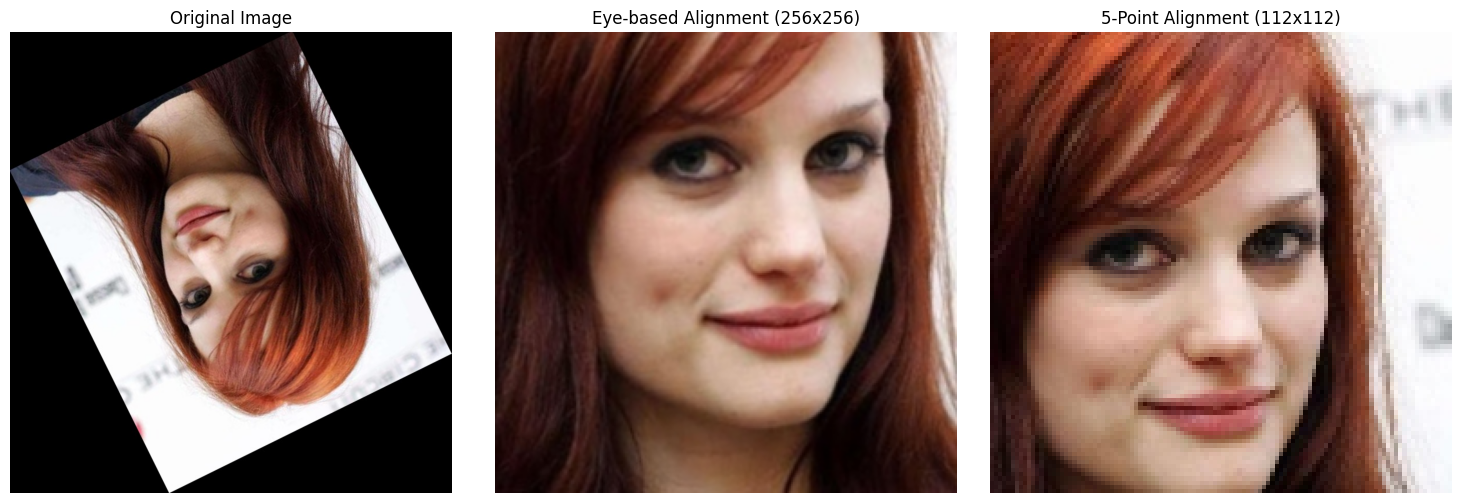

5-point aligned face shape: (112, 112, 3)


In [13]:

# Apply 5-point face alignment
if preds is not None and len(preds) > 0:
    aligned_face_5pt = align_face_5points(input, preds[0])
    
    # Display comparison
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original
    axes[0].imshow(input)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Eye-based alignment
    axes[1].imshow(aligned_face)
    axes[1].set_title('Eye-based Alignment (256x256)')
    axes[1].axis('off')
    
    # 5-point alignment
    axes[2].imshow(aligned_face_5pt)
    axes[2].set_title('5-Point Alignment (112x112)')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"5-point aligned face shape: {aligned_face_5pt.shape}")
else:
    print("No faces detected for alignment")


In [89]:


# %%
def visualize_landmarks(image, landmarks, title="Image with Landmarks"):
    """
    Visualize facial landmarks on the image
    """
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    
    # Plot all landmarks
    plt.scatter(landmarks[:, 0], landmarks[:, 1], c='red', s=2)
    
    # Highlight key points
    left_eye = landmarks[36:42].mean(axis=0)
    right_eye = landmarks[42:48].mean(axis=0)
    nose_tip = landmarks[30]
    mouth_center = landmarks[48:68].mean(axis=0)
    
    plt.scatter(*left_eye, c='blue', s=50, label='Left Eye Center')
    plt.scatter(*right_eye, c='green', s=50, label='Right Eye Center')
    plt.scatter(*nose_tip, c='yellow', s=50, label='Nose Tip')
    plt.scatter(*mouth_center, c='purple', s=50, label='Mouth Center')
    
    plt.title(title)
    plt.legend()
    plt.axis('off')
    plt.show()


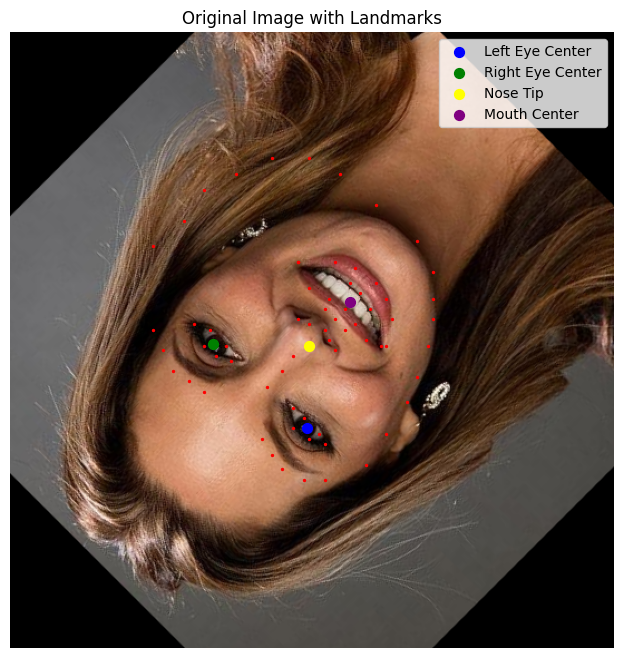

NameError: name 'aligned_face_5pt' is not defined

In [122]:

# Visualize landmarks on original image
if preds is not None and len(preds) > 0:
    visualize_landmarks(input, preds[0], "Original Image with Landmarks")
    
    # Save aligned faces
    from PIL import Image
    import os
    
    # Create output directory
    output_dir = "aligned_faces"
    os.makedirs(output_dir, exist_ok=True)
    
    # Save aligned faces
    Image.fromarray(aligned_face).save(f"{output_dir}/aligned_256x256.jpg")
    Image.fromarray(aligned_face_5pt).save(f"{output_dir}/aligned_5point_112x112.jpg")
    
    print(f"Aligned faces saved to '{output_dir}' directory:")
    print(f"- aligned_256x256.jpg (eye-based alignment)")
    print(f"- aligned_5point_112x112.jpg (5-point alignment)")
    
    # Display final comparison with different sizes
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    # Original with landmarks
    axes[0,0].imshow(input)
    axes[0,0].scatter(preds[0][:, 0], preds[0][:, 1], c='red', s=1)
    axes[0,0].set_title('Original with Landmarks')
    axes[0,0].axis('off')
    
    # Eye-based alignment
    axes[0,1].imshow(aligned_face)
    axes[0,1].set_title('Eye-based Alignment (256x256)')
    axes[0,1].axis('off')
    
    # 5-point alignment
    axes[1,0].imshow(aligned_face_5pt)
    axes[1,0].set_title('5-Point Alignment (112x112)')
    axes[1,0].axis('off')
    
    # 5-point alignment resized to 256x256 for comparison
    aligned_5pt_large = align_face_5points(input, preds[0], output_size=(256, 256))
    axes[1,1].imshow(aligned_5pt_large)
    axes[1,1].set_title('5-Point Alignment (256x256)')
    axes[1,1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No faces detected for processing")




# **Image Pre-Processing Testing**

In [6]:
# code to rotate an image by a specified angle
# import cv2
# import matplotlib.pyplot as plt
# import numpy as np

def rotate_image(image_path, angle):
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get the image center
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)

    # Get the rotation matrix
    rot_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Rotate the image
    rotated = cv2.warpAffine(image, rot_matrix, (w, h), flags=cv2.INTER_LINEAR)

    # Plot original and rotated image
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title(f"Rotated by {angle}°")
    plt.imshow(rotated)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return rotated




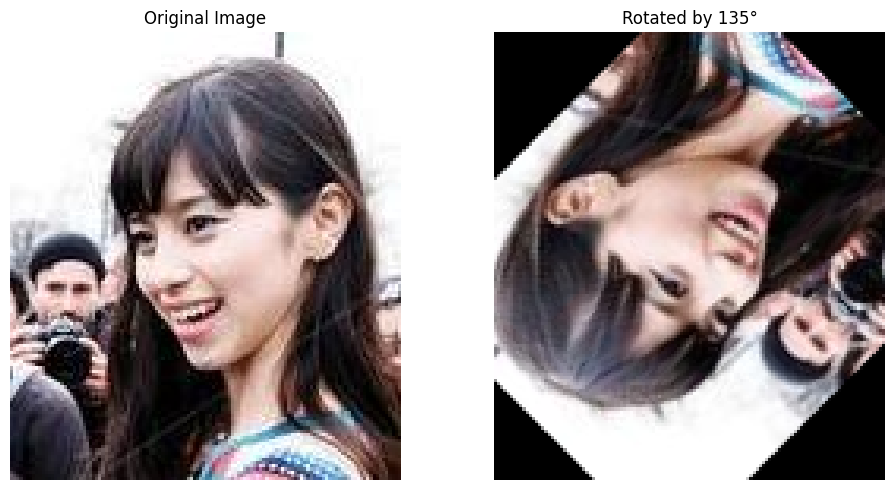

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [46]:
# Example usage:
image_path = "/Users/ravee/Downloads/VGGFace2Kaggle/train/n000009/0348_01.jpg"
rotate_angle = 135  # Replace with any angle (positive or negative)
rotate_image(image_path, rotate_angle)

In [70]:
import random

In [ ]:

# Eamples of Image didnt aligned correctly, so we will try with another image
# mostly it fales for the anlges between 165 and 185
# Half face needs to be removed of flagged

image_path = "/Users/ravee/Downloads/VGGFace2Kaggle/train/n000011/0009_01.jpg"
"/Users/ravee/Downloads/VGGFace2Kaggle/train/n000012/0011_03.jpg"

# few of the forehead part got cropped
"/Users/ravee/Downloads/VGGFace2Kaggle/train/n000017/0011_01.jpg"

# Half Face 
"/Users/ravee/Downloads/VGGFace2Kaggle/train/n000040/0140_01.jpg"
# No Face detected
"/Users/ravee/Downloads/VGGFace2Kaggle/train/n000040/0217_01.jpg"
"/Users/ravee/Downloads/VGGFace2Kaggle/train/n000040/0222_01.jpg"



In [ ]:
rotaion_angle = random.randint(25, 360)

Selected rotation angle: 210 degrees


Rotate angle: 165


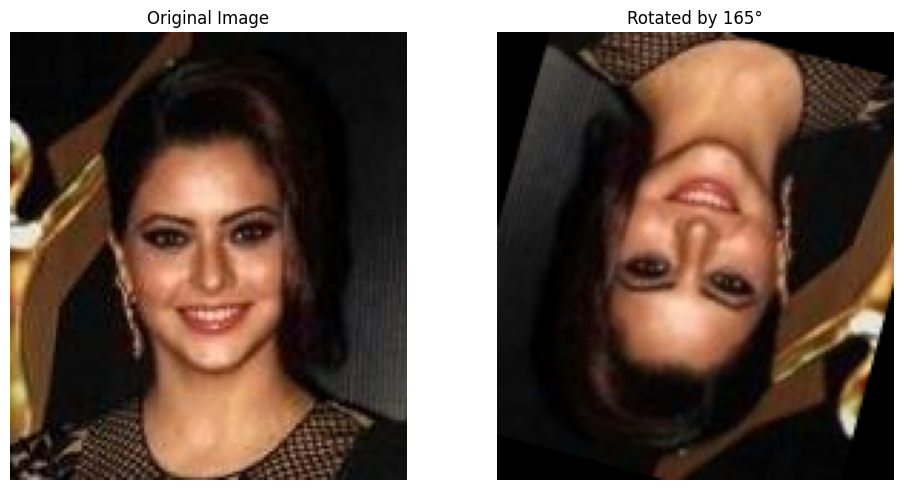

Image shape: (157, 139, 3)
Image shape: (157, 139, 3)
Found 1 face(s)
Face 1: 68 landmarks detected


In [29]:

image_path = "/Users/ravee/Downloads/VGGFace2Kaggle/train/n000011/0009_01.jpg"
rotate_angle = 165
# rotate_angle = rotaion_angle = random.randint(25, 360) # 175  # Replace with any angle (positive or negative)
print(f"Rotate angle: {rotate_angle}")

input = rotate_image(image_path, rotate_angle)

# Convert RGBA to RGB if necessary (remove alpha channel)
print(f"Image shape: {input.shape}")
if input.shape[-1] == 4:
    input = input[:, :, :3]

print(f"Image shape: {input.shape}")
preds = fa.get_landmarks(input)

if preds is not None:
    print(f"Found {len(preds)} face(s)")
    for i, landmarks in enumerate(preds):
        print(f"Face {i+1}: {landmarks.shape[0]} landmarks detected")
else:
    print("No faces detected")



Aligning face with angle: -107.33 degrees at center: (73.83332824707031, 67.25) with landmarks: 68 points and image shape: (157, 139, 3)
Rotation matrix: [[ -0.29788958  -0.95460033 160.02437981]
 [  0.95460033  -0.29788958  16.80175434]]
Rotated image shape: (157, 139, 3)


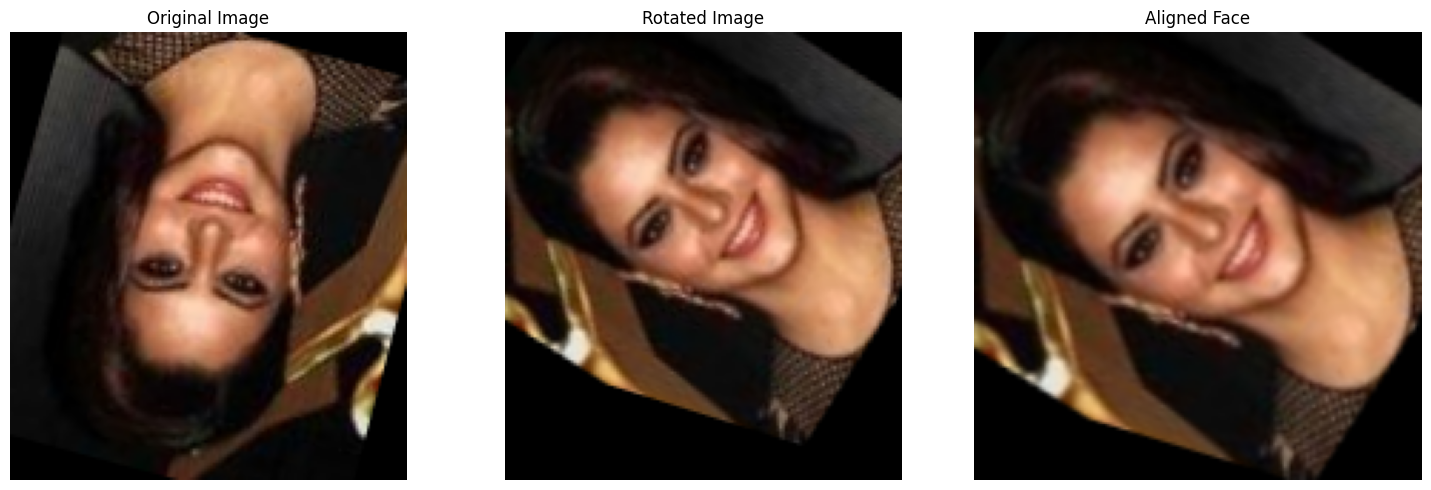

Original image shape: (157, 139, 3)
Aligned face shape: (256, 256, 3)


In [30]:

# Apply face alignment
if preds is not None and len(preds) > 0:
    aligned_face, rotated_image = align_face(input, preds[0])
    
    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(input)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Rotated image
    axes[1].imshow(rotated_image)
    axes[1].set_title('Rotated Image')
    axes[1].axis('off')
    
    # Aligned face
    axes[2].imshow(aligned_face)
    axes[2].set_title('Aligned Face')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Original image shape: {input.shape}")
    print(f"Aligned face shape: {aligned_face.shape}")
else:
    print("No faces detected for alignment")



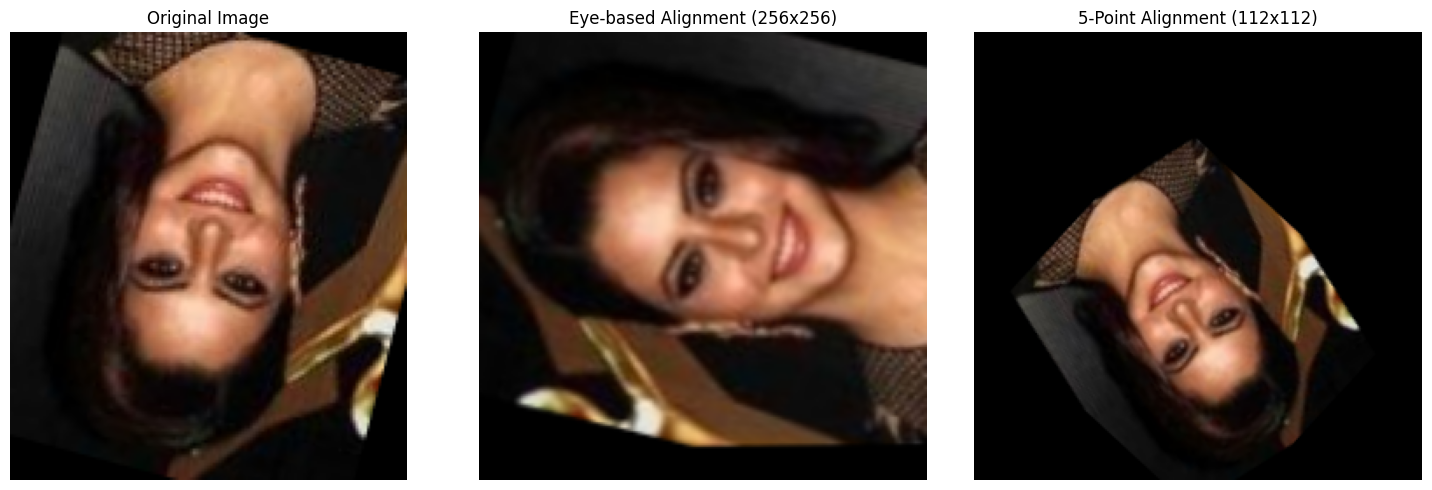

5-point aligned face shape: (256, 256, 3)


In [219]:

# Apply 5-point face alignment
if preds is not None and len(preds) > 0:
    aligned_face_5pt = align_face_5points(input, preds[0])
    
    # Display comparison
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original
    axes[0].imshow(input)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Eye-based alignment
    axes[1].imshow(aligned_face)
    axes[1].set_title('Eye-based Alignment (256x256)')
    axes[1].axis('off')
    
    # 5-point alignment
    axes[2].imshow(aligned_face_5pt)
    axes[2].set_title('5-Point Alignment (112x112)')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"5-point aligned face shape: {aligned_face_5pt.shape}")
else:
    print("No faces detected for alignment")


In [88]:

# Visualize landmarks on original image
if preds is not None and len(preds) > 0:
    visualize_landmarks(input, preds[0], "Original Image with Landmarks")
    
    # Save aligned faces
    from PIL import Image
    import os
    
    # Create output directory
    output_dir = "aligned_faces"
    os.makedirs(output_dir, exist_ok=True)
    
    # Save aligned faces
    Image.fromarray(aligned_face).save(f"{output_dir}/aligned_256x256.jpg")
    Image.fromarray(aligned_face_5pt).save(f"{output_dir}/aligned_5point_112x112.jpg")
    
    print(f"Aligned faces saved to '{output_dir}' directory:")
    print(f"- aligned_256x256.jpg (eye-based alignment)")
    print(f"- aligned_5point_112x112.jpg (5-point alignment)")
    
    # Display final comparison with different sizes
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    # Original with landmarks
    axes[0,0].imshow(input)
    axes[0,0].scatter(preds[0][:, 0], preds[0][:, 1], c='red', s=1)
    axes[0,0].set_title('Original with Landmarks')
    axes[0,0].axis('off')
    
    # Eye-based alignment
    axes[0,1].imshow(aligned_face)
    axes[0,1].set_title('Eye-based Alignment (256x256)')
    axes[0,1].axis('off')
    
    # 5-point alignment
    axes[1,0].imshow(aligned_face_5pt)
    axes[1,0].set_title('5-Point Alignment (112x112)')
    axes[1,0].axis('off')
    
    # 5-point alignment resized to 256x256 for comparison
    aligned_5pt_large = align_face_5points(input, preds[0], output_size=(256, 256))
    axes[1,1].imshow(aligned_5pt_large)
    axes[1,1].set_title('5-Point Alignment (256x256)')
    axes[1,1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No faces detected for processing")




NameError: name 'visualize_landmarks' is not defined

In [225]:
import cv2
import numpy as np
from insightface.app import FaceAnalysis
from insightface.utils import face_align

# Initialize the face analysis app
face_app = FaceAnalysis(name="buffalo_l", providers=['CPUExecutionProvider'])
face_app.prepare(ctx_id=0, det_size=(640, 640))

def preprocess_face(image_path, output_size=(224, 224)):
    # img = cv2.imread(image_path)
    img = image_path
    faces = face_app.get(img)

    if len(faces) == 0:
        print("No face detected.")
        return None

    # Assume first face is primary
    face = faces[0]

    # Extract facial landmarks
    landmarks = face.kps  # numpy array with shape (5, 2)

    # Align the face (InsightFace utility)
    aligned_face = face_align.norm_crop(img, landmarks, image_size=output_size[0])

    plt.imshow(aligned_face)
    plt.title(f"Aligned Face ({output_size[0]}x{output_size[1]})")
    plt.axis('off') 
    return aligned_face



Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/ravee/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/ravee/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/ravee/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/ravee/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/ravee/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
se

/Users/ravee/Documents/Projects/tf-env/lib/python3.11/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


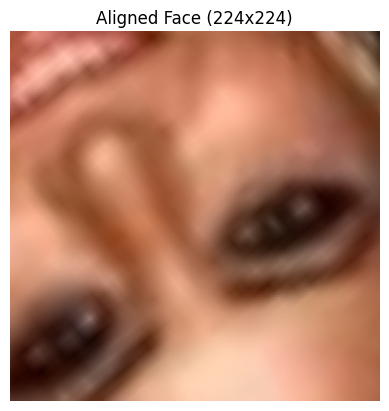

In [226]:
# === USAGE EXAMPLE ===
# input_path = "path_to_your_image.jpg"
# output_path = "aligned_output.jpg"

result = preprocess_face(input)

# if result is not None:
#     cv2.imwrite(output_path, result)
#     print(f"Aligned face saved to {output_path}")
# else:
#     print("Face alignment failed.")


In [1]:
import cv2
import matplotlib.pyplot as plt
from skimage.transform import SimilarityTransform
import numpy as np


Rotate angle: 165


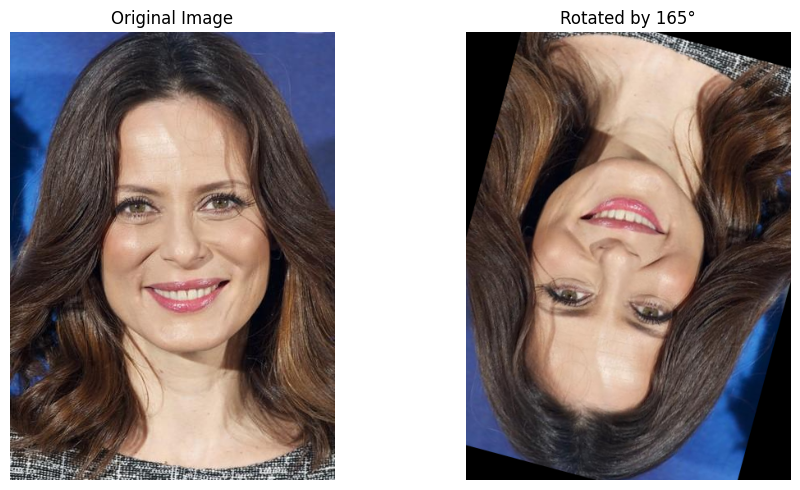

Image shape: (546, 396, 3)
Image shape: (546, 396, 3)
Found 1 face(s)
Face 1: 68 landmarks detected


In [20]:

image_path = "/Users/ravee/Downloads/VGGFace2Kaggle/train/n000150/0005_01.jpg"
rotate_angle = 165
# rotate_angle = rotaion_angle = random.randint(25, 360) # 175  # Replace with any angle (positive or negative)
print(f"Rotate angle: {rotate_angle}")

input = rotate_image(image_path, rotate_angle)

# Convert RGBA to RGB if necessary (remove alpha channel)
print(f"Image shape: {input.shape}")
if input.shape[-1] == 4:
    input = input[:, :, :3]

print(f"Image shape: {input.shape}")
preds = fa.get_landmarks(input)

if preds is not None:
    print(f"Found {len(preds)} face(s)")
    for i, landmarks in enumerate(preds):
        print(f"Face {i+1}: {landmarks.shape[0]} landmarks detected")
else:
    print("No faces detected")



In [21]:
# Write the aligned image to the file
cv2.imwrite("aligned_fixed_185_1.jpg", input)

True

In [11]:
import cv2
import numpy as np

def align_face_2(image, landmarks, output_size=(256, 256)):
    """
    Align face based on eye positions and handle upside-down rotations.
    """
    # Calculate eye centers
    left_eye_center = landmarks[36:42].mean(axis=0)  # Left eye
    right_eye_center = landmarks[42:48].mean(axis=0)  # Right eye

    # Compute angle between eyes
    dx = right_eye_center[0] - left_eye_center[0]
    dy = right_eye_center[1] - left_eye_center[1]
    angle = np.arctan2(dy, dx) * 180. / np.pi

    # Midpoint between eyes
    eye_center = ((left_eye_center[0] + right_eye_center[0]) / 2,
                  (left_eye_center[1] + right_eye_center[1]) / 2)

    print(f"Aligning face with angle: {angle:.2f} degrees")

    # Rotate image to align eyes horizontally
    rot_matrix = cv2.getRotationMatrix2D(eye_center, angle, 1.0)
    rotated = cv2.warpAffine(image, rot_matrix, (image.shape[1], image.shape[0]))

    # Rotate landmarks
    ones = np.ones((landmarks.shape[0], 1))
    landmarks_ones = np.hstack([landmarks, ones])
    new_landmarks = rot_matrix.dot(landmarks_ones.T).T

    # Check if face is upside-down even after rotation
    left_eye_new = new_landmarks[36:42].mean(axis=0)
    right_eye_new = new_landmarks[42:48].mean(axis=0)

    if left_eye_new[1] > right_eye_new[1]:
        print("Detected upside-down face. Rotating 180 degrees...")
        h, w = rotated.shape[:2]
        rotated = cv2.rotate(rotated, cv2.ROTATE_180)

        # Apply 180° to landmarks
        rotation_matrix_180 = cv2.getRotationMatrix2D((w//2, h//2), 180, 1.0)
        new_landmarks = rotation_matrix_180.dot(new_landmarks.T).T

    # Get bounding box with padding
    min_x, min_y = new_landmarks.min(axis=0)
    max_x, max_y = new_landmarks.max(axis=0)

    padding = 50
    min_x = max(0, int(min_x - padding))
    min_y = max(0, int(min_y - padding))
    max_x = min(rotated.shape[1], int(max_x + padding))
    max_y = min(rotated.shape[0], int(max_y + padding))

    # Crop and resize
    cropped = rotated[min_y:max_y, min_x:max_x]
    if cropped.size == 0:
        print("Cropping failed. Returning rotated image.")
        return cv2.resize(rotated, output_size), rotated

    aligned = cv2.resize(cropped, output_size)

    return aligned, rotated


In [12]:

# Apply face alignment
if preds is not None and len(preds) > 0:
    aligned_face, rotated_image = align_face_2(input, preds[0])
    
    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(input)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Rotated image
    axes[1].imshow(rotated_image)
    axes[1].set_title('Rotated Image')
    axes[1].axis('off')
    
    # Aligned face
    axes[2].imshow(aligned_face)
    axes[2].set_title('Aligned Face')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Original image shape: {input.shape}")
    print(f"Aligned face shape: {aligned_face.shape}")
else:
    print("No faces detected for alignment")



Aligning face with angle: -137.68 degrees
Detected upside-down face. Rotating 180 degrees...


ValueError: shapes (2,3) and (2,68) not aligned: 3 (dim 1) != 2 (dim 0)

In [1]:
import cv2
import matplotlib.pyplot as plt
from skimage.transform import SimilarityTransform
import numpy as np


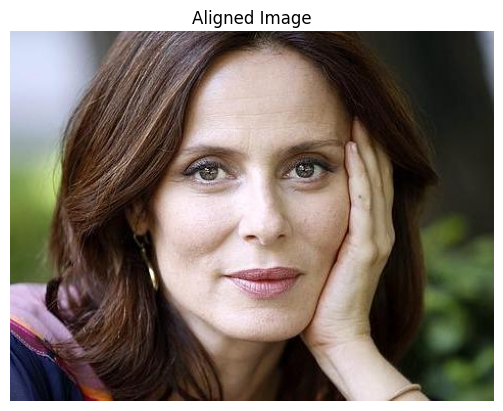

In [6]:
# Write the aligned image to the file
# cv2.imwrite("aligned_fixed.jpg", input)
image_path_fo = '/Users/ravee/Downloads/VGGFace2Kaggle/train/n000150/0010_01.jpg'

image_fo = cv2.imread(image_path_fo)
image_fo = cv2.cvtColor(image_fo, cv2.COLOR_BGR2RGB)
plt.imshow(image_fo)
plt.title("Aligned Image")
plt.axis('off')
plt.show()

'aligned_fixed.jpg'

In [3]:
import cv2
import numpy as np
from faceorienter import FaceOrienter
from insightface.app import FaceAnalysis
from insightface.utils import face_align

# Initialize orientation fixer
fo = FaceOrienter(image_path_fo)

# Initialize InsightFace face analysis
fa = FaceAnalysis(name="buffalo_l", providers=['CPUExecutionProvider'])
fa.prepare(ctx_id=0, det_size=(640, 640))

def robust_align(img_path, output_size=(256,256)):
    img = cv2.imread(img_path)
    orientation = fo.predict_orientation()  # up/down/left/right
    print("Detected orientation:", orientation)
    img = fo.fix_orientation()  # auto-rotated CV image
    plt.imshow(img)
    plt.title(f"Image after orientation fix: {orientation}")
    plt.axis('off')

    # Face detection and landmarks
    faces = fa.get(img)
    if not faces:
        raise Exception("No face detected")
    landmarks = faces[0].kps.astype(np.float32)  # 5 landmarks

    # Affine alignment based on eyes
    aligned = face_align.norm_crop(img, landmarks, image_size=output_size[0])
    return aligned


/Users/ravee/Documents/Projects/tf-env/lib/python3.11/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.22). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/ravee/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/ravee/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/ravee/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/ravee/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/ravee/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
se

Detected orientation: down


(-0.5, 255.5, 255.5, -0.5)

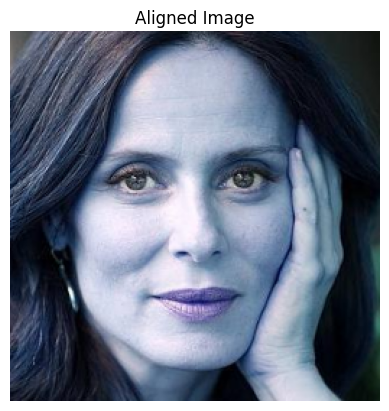

In [7]:

# Initialize orientation fixer
fo = FaceOrienter(image_path_fo)
# Example usage
aligned = robust_align("/Users/ravee/Downloads/VGGFace2Kaggle/train/n000150/0010_01.jpg")
# cv2.imwrite("aligned_fixed.jpg", aligned)
plt.imshow(aligned)
plt.title("Aligned Image")
plt.axis('off')


In [8]:
import cv2
import numpy as np
import face_alignment
from skimage import io


In [ ]:

# Initialize the 2D landmark detector
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D, flip_input=True, device='cpu')

def robust_align(img_path, output_size=(256, 256)):
    img = io.imread(img_path)
    preds = fa.get_landmarks(img)
    # print(f"Predicted landmarks: {preds}")
    if preds is None or len(preds) == 0:
        raise ValueError("No face detected")

    lm = preds[0]  # 68 landmarks: x,y

    # Eyes landmarks indices (0-based)
    left_eye = lm[36:42].mean(axis=0)
    right_eye = lm[42:48].mean(axis=0)
    nose = lm[30]

    # Compute rotation angle
    dx, dy = right_eye - left_eye
    angle = np.degrees(np.arctan2(dy, dx))
    center = tuple((left_eye + right_eye) / 2)

    # Rotate upright
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    # If upside-down, detect by eyes below nose
    # Transform landmarks
    lm1 = np.hstack([lm, np.ones((68,1))])
    lm_rot = (M @ lm1.T).T
    if np.mean(lm_rot[36:42,1]) > nose[1]:  # left eye below nose
        rotated = cv2.rotate(rotated, cv2.ROTATE_180)
        H, W = rotated.shape[:2]
        M2 = cv2.getRotationMatrix2D((W/2, H/2), 180, 1.0)
        lm_rot = (M2 @ np.hstack([lm_rot, np.ones((68,1))]).T).T

    # Crop tight bounding box around landmarks
    x_min, y_min = np.min(lm_rot, axis=0).astype(int)
    x_max, y_max = np.max(lm_rot, axis=0).astype(int)
    pad = 20
    cropped = rotated[max(y_min-pad,0):min(y_max+pad, rotated.shape[0]),
                      max(x_min-pad,0):min(x_max+pad, rotated.shape[1])]

    aligned = cv2.resize(cropped, output_size)
    return aligned




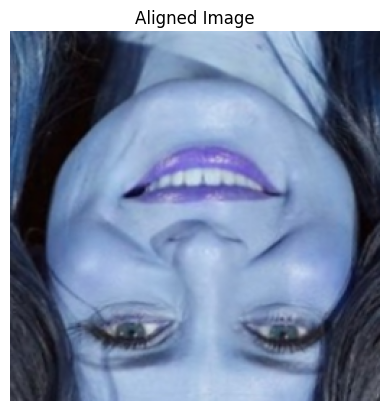

In [24]:
aligned = robust_align("/Users/ravee/Documents/Projects/FaceRecognition/Satschel/bio.api/FacePreProcessing/aligned_fixed_185_1.jpg")
plt.imshow(aligned)
plt.title("Aligned Image")
plt.axis('off')
plt.show()


In [33]:
# Initialize face-alignment detector
# fa = face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D, flip_input=True, device='cpu')

def robust_align_with_nose_check(img_path, output_size=(256, 256)):
    # img = io.imread(img_path)
    img = img_path
    preds = fa.get_landmarks(img)
    if preds is None or len(preds) == 0:
        raise ValueError("No face detected")

    lm = preds[0]  # 68 landmarks
    left_eye = lm[36:42].mean(axis=0)
    right_eye = lm[42:48].mean(axis=0)
    nose = lm[30]

    # Align face using eyes
    dx, dy = right_eye - left_eye
    angle = np.degrees(np.arctan2(dy, dx))
    eye_center = tuple((left_eye + right_eye) / 2)

    M = cv2.getRotationMatrix2D(eye_center, angle, 1.0)
    rotated = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

    # Transform landmarks
    ones = np.ones((lm.shape[0], 1))
    lm_h = np.hstack([lm, ones])
    lm_rot = (M @ lm_h.T).T

    # Check if nose is below eye line
    avg_eye_y = (lm_rot[36:42,1].mean() + lm_rot[42:48,1].mean()) / 2
    nose_y = lm_rot[30,1]

    if nose_y < avg_eye_y:  # If nose is above eyes => upside down
        print("Detected upside-down face after alignment, rotating 180 degrees...")
        rotated = cv2.rotate(rotated, cv2.ROTATE_180)

        # Apply 180° rotation to landmarks
        h, w = rotated.shape[:2]
        M2 = cv2.getRotationMatrix2D((w/2, h/2), 180, 1.0)
        lm_rot = (M2 @ np.hstack([lm_rot, np.ones((68,1))]).T).T

    # Crop face using landmark box + padding
    min_x, min_y = np.min(lm_rot, axis=0).astype(int)
    max_x, max_y = np.max(lm_rot, axis=0).astype(int)
    pad = 20
    min_x, min_y = max(min_x - pad, 0), max(min_y - pad, 0)
    max_x, max_y = min(max_x + pad, rotated.shape[1]), min(max_y + pad, rotated.shape[0])

    cropped = rotated[min_y:max_y, min_x:max_x]
    aligned = cv2.resize(cropped, output_size)

    return aligned


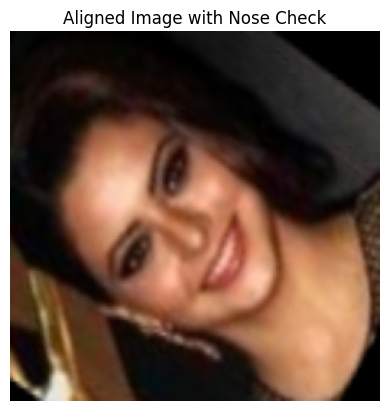

In [34]:
input_path = "/Users/ravee/Documents/Projects/FaceRecognition/Satschel/bio.api/FacePreProcessing/aligned_fixed_185_1.jpg"
aligned = robust_align_with_nose_check(input)
plt.imshow(aligned)
plt.title("Aligned Image with Nose Check")
plt.axis('off')
plt.show()



# **Final code to check if eyes are above nose**

In [4]:
import cv2
import numpy as np
import face_alignment
import matplotlib.pyplot as plt


In [5]:

# Initialize face alignment with CPU
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D, flip_input=False, device='cpu')

def rotate_image_2(image, angle):
    """Rotate the image around its center by the given angle."""
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    rot_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, rot_matrix, (w, h)), rot_matrix

def are_eyes_above_nose(landmarks):
    left_eye_y = landmarks[36:42, 1].mean()
    right_eye_y = landmarks[42:48, 1].mean()
    nose_y = landmarks[30, 1]
    mouth_center = landmarks[48:68].mean()
    print(f"Left eye Y: {left_eye_y}, Right eye Y: {right_eye_y}, Nose Y: {nose_y}, Mouth center: {mouth_center}")
    return left_eye_y < nose_y and right_eye_y < nose_y and  nose_y < mouth_center

def auto_upright_image(image):
    max_attempts = 10  # 360° / 20° steps
    angle = 0

    for _ in range(max_attempts):
        preds = fa.get_landmarks(image)
        print(f"Attempting angle: {angle}° - Found {len(preds) if preds else 0} face(s)")
        if preds and are_eyes_above_nose(preds[0]):
            print(f"Face is upright at angle: {angle}°")
            return image, preds[0]
        image, _ = rotate_image_2(image, 35)
        angle += 35

    raise Exception("Failed to detect upright face within 360 degrees.")

def align_face(image, landmarks, output_size=(256, 256)):
    left_eye_center = landmarks[36:42].mean(axis=0)
    right_eye_center = landmarks[42:48].mean(axis=0)
    
    dx = right_eye_center[0] - left_eye_center[0]
    dy = right_eye_center[1] - left_eye_center[1]
    angle = np.arctan2(dy, dx) * 180 / np.pi
    eye_center = ((left_eye_center[0] + right_eye_center[0]) / 2,
                  (left_eye_center[1] + right_eye_center[1]) / 2)
    
    print(f"Aligning face with angle: {angle:.2f} degrees")
    rot_matrix = cv2.getRotationMatrix2D(eye_center, angle, 1.0)
    rotated = cv2.warpAffine(image, rot_matrix, (image.shape[1], image.shape[0]))

    ones = np.ones(shape=(len(landmarks), 1))
    landmarks_ones = np.hstack([landmarks, ones])
    new_landmarks = rot_matrix.dot(landmarks_ones.T).T

    min_x, min_y = new_landmarks.min(axis=0)
    max_x, max_y = new_landmarks.max(axis=0)

    padding = 50
    min_x = max(0, int(min_x - padding))
    min_y = max(0, int(min_y - padding))
    max_x = min(rotated.shape[1], int(max_x + padding))
    max_y = min(rotated.shape[0], int(max_y + padding))

    cropped = rotated[min_y:max_y, min_x:max_x]
    aligned = cv2.resize(cropped, output_size)

    return aligned, rotated

In [ ]:
# Eamples of Image didnt aligned correctly, so we will try with another image
# mostly it fales for the anlges between 165 and 185
# Half face needs to be removed of flagged

image_path = "/Users/ravee/Downloads/VGGFace2Kaggle/train/n000011/0009_01.jpg"
"/Users/ravee/Downloads/VGGFace2Kaggle/train/n000012/0011_03.jpg"

# few of the forehead part got cropped
"/Users/ravee/Downloads/VGGFace2Kaggle/train/n000017/0011_01.jpg"

# Half Face 
"/Users/ravee/Downloads/VGGFace2Kaggle/train/n000040/0140_01.jpg"
# No Face detected
"/Users/ravee/Downloads/VGGFace2Kaggle/train/n000040/0217_01.jpg"
"/Users/ravee/Downloads/VGGFace2Kaggle/train/n000040/0222_01.jpg"

# Didnt work 
"/Users/ravee/Downloads/VGGFace2Kaggle/train/n000220/0017_01.jpg" -- 165

"/Users/ravee/Downloads/VGGFace2Kaggle/train/n000230/0007_01.jpg" -- 175



# Need some improvement for these kind of pics, Check in detail whats wrong 
"/Users/ravee/Downloads/VGGFace2Kaggle/train/n000261/0037_01.jpg"

# Need to be added

# 1. first find face, if not stop right there and dont move
# 2. if face is not upright, rotate it until it is upright
# 3. if face is upside down, rotate it 180 degrees
# 4. align face based on eyes and crop it
# 5. if more than 2 faces are detected, raise an error stated more than 2 faces detected



Rotate angle: -45


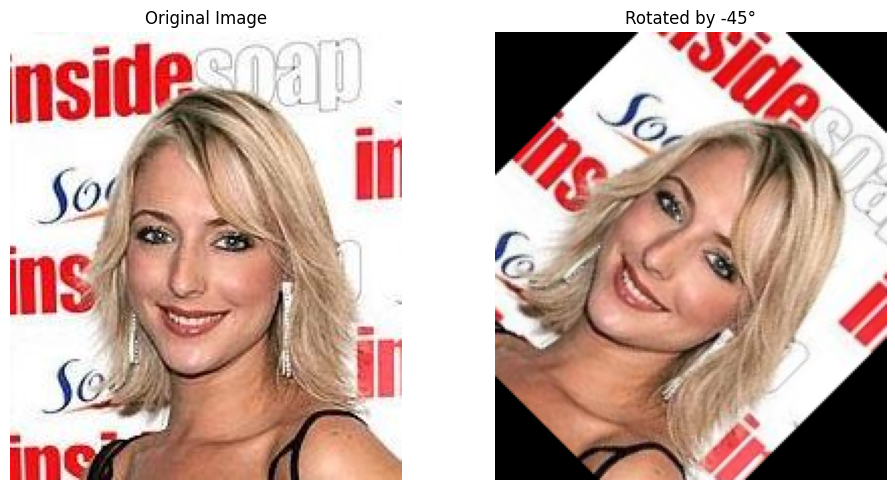

Image shape: (222, 194, 3)
Image shape: (222, 194, 3)
Found 1 face(s)
Face 1: 68 landmarks detected


In [14]:
image_path = "/Users/ravee/Downloads/VGGFace2Kaggle/train/n000319/0003_01.jpg"
rotate_angle = -45
# rotate_angle = rotaion_angle = random.randint(25, 360) # 175  # Replace with any angle (positive or negative)
print(f"Rotate angle: {rotate_angle}")

input = rotate_image(image_path, rotate_angle)

# Convert RGBA to RGB if necessary (remove alpha channel)
print(f"Image shape: {input.shape}")
if input.shape[-1] == 4:
    input = input[:, :, :3]

print(f"Image shape: {input.shape}")
preds = fa.get_landmarks(input)

if preds is not None:
    print(f"Found {len(preds)} face(s)")
    for i, landmarks in enumerate(preds):
        print(f"Face {i+1}: {landmarks.shape[0]} landmarks detected")
else:
    print("No faces detected")


In [15]:
cv2.imwrite(f"rotated_{rotate_angle}_.jpg", input)


True

Attempting angle: 0° - Found 1 face(s)
Left eye Y: 355.1666564941406, Right eye Y: 294.0, Nose Y: 280.0, Mouth center: 265.625
Attempting angle: 35° - Found 1 face(s)
Left eye Y: 336.5, Right eye Y: 292.6666564941406, Nose Y: 278.0, Mouth center: 294.6499938964844
Attempting angle: 70° - Found 1 face(s)
Left eye Y: 299.3333435058594, Right eye Y: 364.6666564941406, Nose Y: 288.0, Mouth center: 239.1999969482422
Attempting angle: 105° - Found 1 face(s)
Left eye Y: 249.8333282470703, Right eye Y: 353.1666564941406, Nose Y: 285.0, Mouth center: 243.8000030517578
Attempting angle: 140° - Found 1 face(s)
Left eye Y: 211.5, Right eye Y: 315.1666564941406, Nose Y: 286.0, Mouth center: 259.2250061035156
Attempting angle: 175° - Found 1 face(s)
Left eye Y: 199.0, Right eye Y: 265.3333435058594, Nose Y: 284.0, Mouth center: 279.3999938964844
Attempting angle: 210° - Found 1 face(s)
Left eye Y: 213.0, Right eye Y: 219.6666717529297, Nose Y: 282.0, Mouth center: 298.8999938964844
Face is upright a

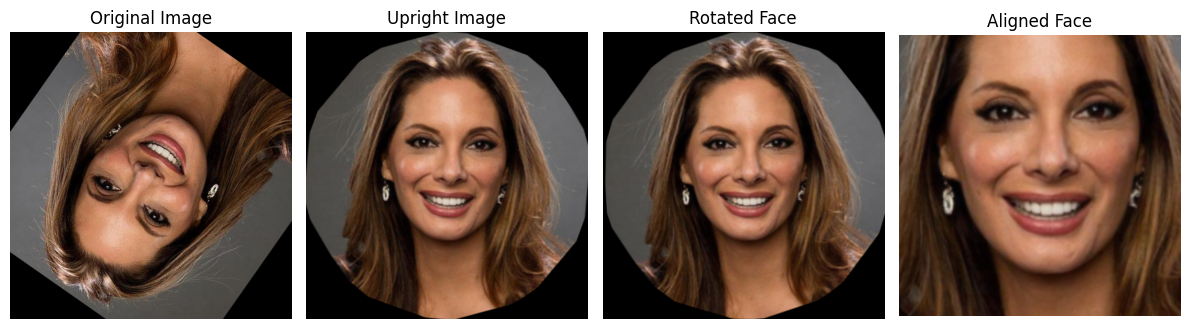

Upright image shape: (553, 542, 3)
Rotated face shape: (553, 542, 3)
Aligned face shape: (256, 256, 3)


In [172]:

# === Usage ===
# input_path = "/Users/ravee/Documents/Projects/FaceRecognition/Satschel/bio.api/FacePreProcessing/aligned_fixed.jpg"
# input = cv2.imread(input_path)

# input = input

if input.shape[-1] == 4:
    input = input[:, :, :3]  # Remove alpha if present

try:
    upright_img, landmarks = auto_upright_image(input)
    aligned_face, rotated_face = align_face(upright_img, landmarks)
    
    # Save or display
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 4, 1)
    plt.imshow(input)
    plt.title("Original Image")
    plt.axis('off')
    plt.subplot(1, 4, 2)
    plt.imshow(upright_img)
    plt.title("Upright Image")
    plt.axis('off')
    plt.subplot(1, 4, 3)
    plt.imshow(rotated_face)
    plt.title("Rotated Face")
    plt.axis('off')
    plt.subplot(1, 4, 4)
    plt.imshow(aligned_face)
    plt.title("Aligned Face")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    print(f"Upright image shape: {upright_img.shape}")
    print(f"Rotated face shape: {rotated_face.shape}")
    print(f"Aligned face shape: {aligned_face.shape}")
except Exception as e:
    print("❌", str(e))


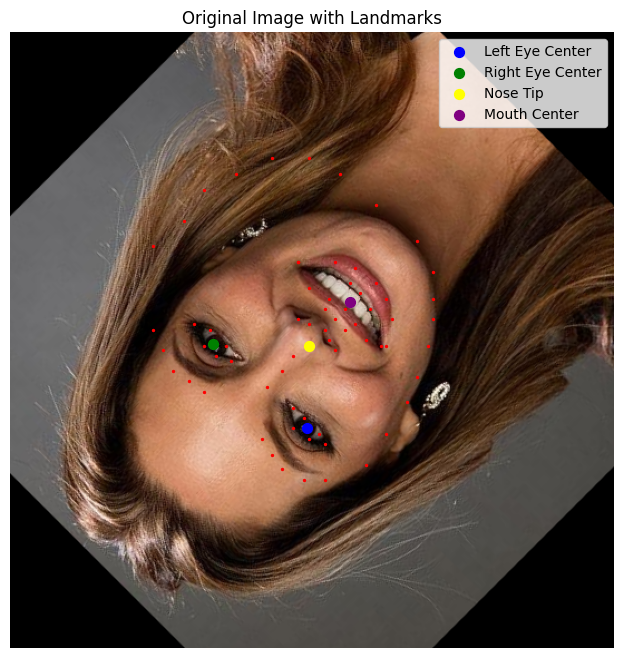

NameError: name 'aligned_face_5pt' is not defined

In [123]:

# Visualize landmarks on original image
if preds is not None and len(preds) > 0:
    visualize_landmarks(input, preds[0], "Original Image with Landmarks")
    
    # Save aligned faces
    from PIL import Image
    import os
    
    # Create output directory
    output_dir = "aligned_faces"
    os.makedirs(output_dir, exist_ok=True)
    
    # Save aligned faces
    Image.fromarray(aligned_face).save(f"{output_dir}/aligned_256x256.jpg")
    Image.fromarray(aligned_face_5pt).save(f"{output_dir}/aligned_5point_112x112.jpg")
    
    print(f"Aligned faces saved to '{output_dir}' directory:")
    print(f"- aligned_256x256.jpg (eye-based alignment)")
    print(f"- aligned_5point_112x112.jpg (5-point alignment)")
    
    # Display final comparison with different sizes
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    # Original with landmarks
    axes[0,0].imshow(input)
    axes[0,0].scatter(preds[0][:, 0], preds[0][:, 1], c='red', s=1)
    axes[0,0].set_title('Original with Landmarks')
    axes[0,0].axis('off')
    
    # Eye-based alignment
    axes[0,1].imshow(aligned_face)
    axes[0,1].set_title('Eye-based Alignment (256x256)')
    axes[0,1].axis('off')
    
    # 5-point alignment
    axes[1,0].imshow(aligned_face_5pt)
    axes[1,0].set_title('5-Point Alignment (112x112)')
    axes[1,0].axis('off')
    
    # 5-point alignment resized to 256x256 for comparison
    aligned_5pt_large = align_face_5points(input, preds[0], output_size=(256, 256))
    axes[1,1].imshow(aligned_5pt_large)
    axes[1,1].set_title('5-Point Alignment (256x256)')
    axes[1,1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No faces detected for processing")




# **Testing with FaceOrienter**

In [158]:
import cv2
import dlib
import numpy as np


In [159]:

# Load dlib models
detector = dlib.get_frontal_face_detector()
# Ensure you've downloaded the 5-point model from dlib:
# http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
predictor = dlib.shape_predictor("/Users/ravee/Documents/Projects/FaceRecognition/Satschel/bio.api/FacePreProcessing/faceorienter/faceorienter/model/shape_predictor_5_face_landmarks.dat")

class SelfFaceOrienter:
    def __init__(self):
        self.rotations = [0, 90, 180, 270]

    def get_landmarks(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        rects = detector(gray, 1)
        if not rects:
            return None
        # Single face only
        shape = predictor(gray, rects[0])
        pts = np.array([(p.x, p.y) for p in shape.parts()])
        return pts

    def predict_orientation(self, img):
        for rot in self.rotations:
            M = cv2.getRotationMatrix2D((img.shape[1]//2, img.shape[0]//2), rot, 1.0)
            img_r = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
            lm = self.get_landmarks(img_r)
            if lm is None: continue

            # eye centers and nose
            eye_l = lm[2]; eye_r = lm[0]; nose = lm[4]
            # nose below eyes vertically → correct ("down")
            if abs((eye_l[1]+eye_r[1])/2 - nose[1]) < abs((eye_l[1]+eye_r[1])/2 - nose[1]):
                return rot
        return 0

    def fix_orientation(self, img):
        rot = self.predict_orientation(img)
        if rot != 0:
            M = cv2.getRotationMatrix2D((img.shape[1]//2, img.shape[0]//2), rot, 1.0)
            img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
        # Final face align (similar to before)
        return img



(-0.5, 395.5, 545.5, -0.5)

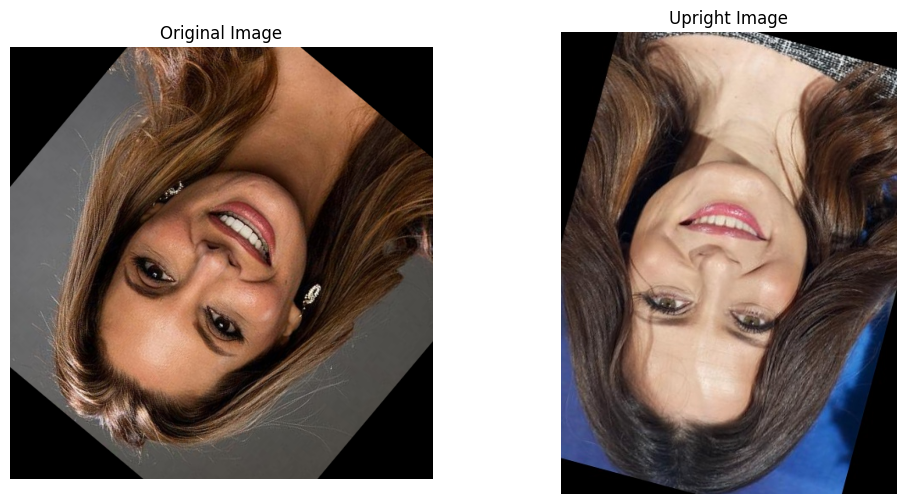

In [160]:
# Usage
img = cv2.imread("/Users/ravee/Documents/Projects/FaceRecognition/Satschel/bio.api/FacePreProcessing/aligned_fixed_185_1.jpg")
fo = SelfFaceOrienter()
upright = fo.fix_orientation(img)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(input)
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(upright)
plt.title("Upright Image")
plt.axis('off')


In [16]:
from example_usage import example_basic_usage, example_custom_settings

image_path = '/Users/ravee/Documents/GitHub/face_preprocessing/rotated_-45_.jpg'
example_basic_usage(image_path)
# example_custom_settings(image_path)

=== Basic Usage Example ===
Loaded image shape: (222, 194, 3)
Found 1 face(s)
Face 1: 68 landmarks detected
Attempt 1/18 at angle: 0° - Found 1 face(s)
Eyes above nose: False, Nose above mouth: True, Upright: False
Face detected but not upright at angle: 0°
Attempt 2/18 at angle: 20° - Found 1 face(s)
Eyes above nose: True, Nose above mouth: True, Upright: True
Face is upright at angle: 20°
Aligning face with angle: 28.10 degrees
Image saved to: aligned_faces/processed_face.jpg
Face processed and saved to: aligned_faces/processed_face.jpg
